In [491]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.metrics import  make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm



# Preprocessing the Data in rating.csv:
def preprocessRatingFile():
    # 1) load the 'ratings' file into ratingdata
    # Show an example of records after preprocessing was applied
    print ("\nSample of the ratingdata before preprocessing")
    ratingdata=pd.read_csv('ratings.csv')
    print (ratingdata.head(5))
    #2.1) remove the 'timestamp' field from the ratingdata because I won't use it
    ratingdata=ratingdata.drop('timestamp', axis = 1)
    df=pd.DataFrame(ratingdata)

    users=np.unique(df['userId'])
    print ("The total number of unique users in the data %i" %np.size(users))
    
    print ("The original ratings in the data before preprocessing" )
    print(np.unique(ratingdata['rating']))
    
    print ("The number of those ratings are %i "%np.size(np.unique(ratingdata['rating'])))
    df['rating']= df['rating'].apply(lambda x: 0 if x>=3 else 1 )
    
    
    return df, users




In [492]:
#preprocessing the 'rating.csv' file
ratingdata,users=preprocessRatingFile()

# Show an example of records after preprocessing was applied
print ("\nSample of the ratingdata after preprocessing")
print (ratingdata.head(5))


Sample of the ratingdata before preprocessing
   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
The total number of unique users in the data 671
The original ratings in the data before preprocessing
[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
The number of those ratings are 10 

Sample of the ratingdata after preprocessing
   userId  movieId  rating
0       1       31       1
1       1     1029       0
2       1     1061       0
3       1     1129       1
4       1     1172       0


The total number of data= 100004
The total number of attributes in the data= 3
The attribute names are:
['userId', 'movieId', 'rating']

After preprocessing the Data and discretizing the ratings into two classes like and dislike
The count of likes= 82170 
The count of dislikes= 17834 

Percentage of movies that were liked: 0.82%
Percentage of movies that were disliked: 0.18%


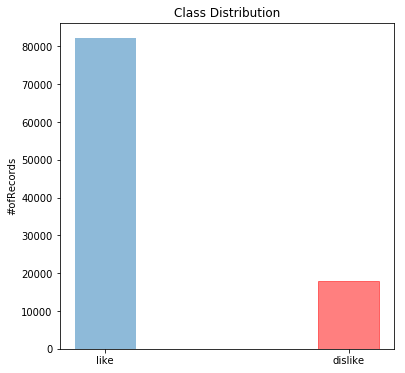

In [435]:
#printing description of the data
print ("The total number of data= %i" %(ratingdata.shape[0]))
print ("The total number of attributes in the data= %i" %(ratingdata.shape[1]))
print ("The attribute names are:")
print (list(ratingdata))
# the classes are inbalanced:
#counting the differnt examples in each class to check if class distribution is balanced or not
print ("\nAfter preprocessing the Data and discretizing the ratings into two classes like and dislike")
likes=(ratingdata['rating']==0).sum()
print ("The count of likes= %i "%likes)
dislikes=(ratingdata['rating']==1).sum()
print ("The count of dislikes= %i \n"%dislikes)
print ("Percentage of movies that were liked: %.2f%%" %(1.0 *likes/ratingdata.shape[0]))
print ("Percentage of movies that were disliked: %.2f%%" %(1.0 *dislikes/ratingdata.shape[0]))
#plooting the distribution of the two classes
classes=('like','dislike')
width = 0.25       # the width of the bars
performance=[]
performance.append((ratingdata['rating']==0).sum())
performance.append((ratingdata['rating']==1).sum())
y_pos = np.arange(len(classes))
x=plt.bar(y_pos, performance, width,align='center', alpha=0.5)
x[1].set_color('r')
plt.xticks(y_pos, classes)
plt.ylabel('#ofRecords')
plt.title('Class Distribution')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size  
plt.savefig('classdistribution')
plt.show()




In [436]:
def preprocessMovieFile():
    #load the movies data into moviedata
    moviedata=pd.read_csv('movies.csv')
    title=moviedata['title']
    print ("The total number of movies= %i" %(moviedata.shape[0]))
    print ("The total number of attributes in the data= %i" %(moviedata.shape[1]))
    print ("The attribute names are:")
    print (list(moviedata))
    print ("\nSample of the moviedata before preprocessing")

    # Show an example of records after preprocessing was applied
    print (moviedata.head(5))
    #Preprocessing Steps:
    #extracting the movie name from the title field which if existed is at the end of value of the field between brackets
    moviedata['moviename']=map(lambda x: x[0:x.rfind("(")] if x.rfind("(") >-1 else x ,title)
    #since the title containes a movie name + year of production we need to seperate the year from the name.
    #if a movie doesnt have a year I put a value of '1980'
    #add a year column to the moviedata after extracting it from the 'title'
    moviedata['year']=map(lambda x: int(x[x.rfind("(") + 1:x.rfind("(")+5]) if x.rfind("(") >-1 else 1980 ,title)
    #add a moviename column to the moviedata after extracting it from the 'title'

    #adding a minmaxyear column to moviedata after applying the Min-Max normalization on the year to get a value between [0, 1]
    #Applying the Min-Max normalization on the year to get a value between [0, 1]
    #min-max=(year-oldmin / (oldmax-oldmin) ) *(newmax-newmin) +newmin
    moviedata['minmaxyear']=map(lambda x: '' if x=='' else round((float((x-min(moviedata['year'])))/float((max(moviedata['year'])-min(moviedata['year']))))*(1-0)+0,3),moviedata['year'])

    #adding scaledyear column to moviedata after Discretizing the year to [old, new, moderate] movie
    #which I will represent by [1, 2, 3]
    #moviedata['scaledyear']=map(lambda x: "old" if x<1980 else "moderate" if x <2000 else "new"  ,moviedata['year'])
    print ("Information required to discretize the year of the movies")
    print ("The maximum year %i" %max(moviedata['year']))
    print ("The minimum year %i" %min(moviedata['year']))
    print ("The middle year %i" %math.floor(np.median(moviedata['year'])))
    moviedata['scaledyear']=map(lambda x: 1 if x<1991 else 2 if x <2000 else 3  ,moviedata['year'])
    #moviedata['scaledyear']=map(lambda x: 1 if x<1997 else 2 if x <1997 else 3  ,moviedata['year'])

    

    #Preparing the genra field for the one-hot-code encoding
    # extracting the unique different genre values
    # counting the number of different genres and removing the (no genres listed) value
    genre=moviedata['genres']
    # print (genre)
    genrelist=[]
    for g in genre:
        x=g.split("|")
        for i in x:
            if i not in genrelist:
                genrelist.append(i)
    genrelist.remove('(no genres listed)')
    print("\nThe different genres for the movies are: ")
    print(genrelist)
    print ("The number of unique genres are %i" %np.size(np.unique(genrelist)))

    #Performing one hot code encodig for genre column
    #adding 19 columns to the data frame which are the number of unique different genres
    
    for g in genrelist:
        moviedata[g]=map(lambda x: 1 if g in x else 0,moviedata['genres'])
    return moviedata,genrelist




In [437]:
#preprocessing the 'movies.csv' file
moviedata,genrelist=preprocessMovieFile()

print ("\nSample of the moviedata after preprocessing")
# Show an example of records after preprocessing was applied
print (moviedata.head(5))

The total number of movies= 9125
The total number of attributes in the data= 3
The attribute names are:
['movieId', 'title', 'genres']

Sample of the moviedata before preprocessing
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Information required to discretize the year of the movies
The maximum year 2016
The minimum year 1902
The middle year 1997

The different genres for the movies are: 
['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'

   rating  movieId         moviename  scaledyear  Adventure  Animation  \
0       1       31  Dangerous Minds            2          0          0   
1       0       31  Dangerous Minds            2          0          0   
2       0       31  Dangerous Minds            2          0          0   

   Children  Comedy  Fantasy  Romance    ...      Thriller  Horror  Mystery  \
0         0       0        0        0    ...             0       0        0   
1         0       0        0        0    ...             0       0        0   
2         0       0        0        0    ...             0       0        0   

   Sci-Fi  Documentary  IMAX  War  Musical  Western  Film-Noir  
0       0            0     0    0        0        0          0  
1       0            0     0    0        0        0          0  
2       0            0     0    0        0        0          0  

[3 rows x 23 columns]
Current figure size: [20, 9]


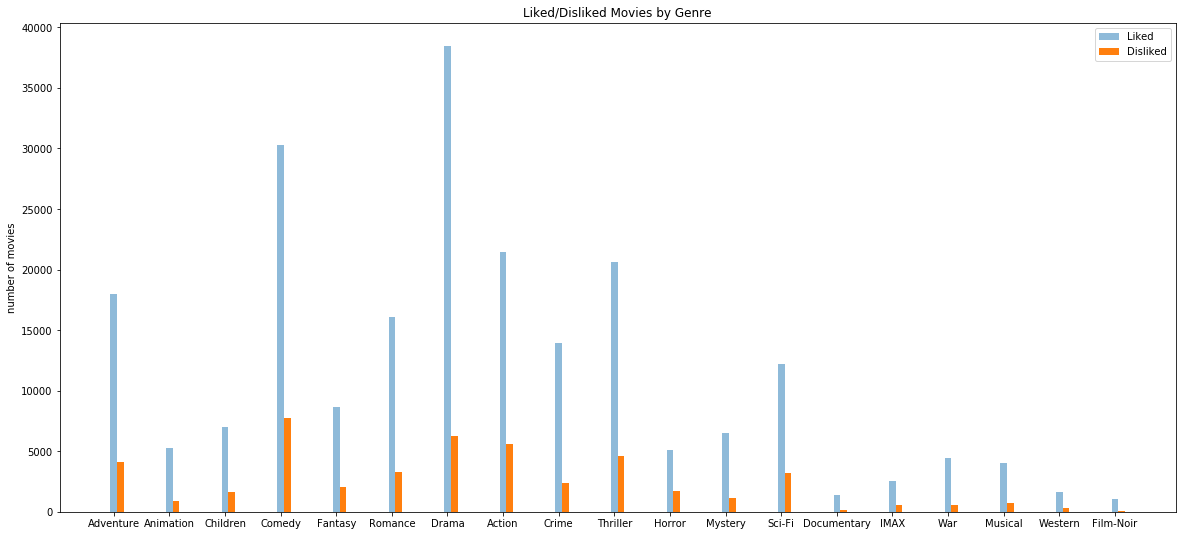

In [441]:
# plotting the distribution of likes and dislikes of movies based on the genre
bigdata=ratingdata[[ 'rating','movieId']].merge(moviedata[['moviename','scaledyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner')
#printing sample of the data
print (bigdata.head(3))

glike=[]
gdislike=[]
#selecting the records were the movies were liked
liked=bigdata[bigdata['rating']==0 ]
#selecting the records were the movies were disliked
disliked=bigdata[bigdata['rating']==1 ]
#counting how many each genre was involved in a movie that was liked and disliked
for g in genrelist:
    glike.append((liked[g]==1).sum())
    gdislike.append((disliked[g]==1).sum())

#plotting the number of movies that was liked and disliked for each movie genre    
glikes = np.array(glike)
gdislikes = np.array(gdislike)
genres=np.array(genrelist)
x=list(range(0,19))
x=[i*5 for i in x]
ind = np.array(x)
width=.60       
plt.bar(ind, glikes, width, label='Liked',alpha=0.5)
plt.bar(ind + width, gdislikes, width,label='Disliked')

plt.ylabel('number of movies')
plt.title('Liked/Disliked Movies by Genre')

plt.xticks(ind , genres)
plt.legend(loc='best')
fig_size = plt.rcParams["figure.figsize"]
 

fig_size[0] = 20
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size 
print "Current figure size:", fig_size
plt.savefig('genres')
plt.show()



In [450]:
#Printing the genres based on the most watch movies with those genres
sorted_glike,sorted_genrelist=[list(x) for x in zip(*sorted(zip(glike, genrelist), key=lambda pair: pair[0]))]
print("Printing the genres starting with the genre that has the highest amount of watched movies and ending with the least")
for i in reversed(sorted_genrelist):print i

Printing the genres starting with the genre that has the highest amount of watched movies and ending with the least
Drama
Comedy
Action
Thriller
Adventure
Romance
Crime
Sci-Fi
Fantasy
Children
Mystery
Animation
Horror
War
Musical
IMAX
Western
Documentary
Film-Noir


In [451]:
#getting the names of the movie that was watched the most, watched the least.
movienames=[]
movienames=list(bigdata['moviename'])
uniquemovienames=[]
for movie in movienames:
    if movie not in uniquemovienames:
        uniquemovienames.append(movie)


moviecount=[]
for  movie in uniquemovienames:
    moviecount.append((bigdata['moviename']==movie).sum())
    
maxapperance=max(moviecount)
maxmovielist=[]
minmovielist=[]
for i in range(0,len(uniquemovienames)):
    if moviecount[i]==maxapperance:
        maxmovielist.append(uniquemovienames[i])
    if moviecount[i]==1:
        minmovielist.append(uniquemovienames[i])  

print("The movie that was watched the most is:%s it was watched by %i user(s)" %(maxmovielist[0],maxapperance))
print("There are  %i unwatched movies" %(len(minmovielist)))


The movie that was watched the most is:Forrest Gump  it was watched by 341 user(s)
There are  2945 unwatched movies


In [391]:
#getting the names of the movie that was liked the most.

likedcount=[]
movielist1=[]
for  movie in uniquemovienames:
    likedcount.append((liked['moviename']==movie).sum())

maxliked=max(likedcount) 
for i in range(0,len(uniquemovienames)):
    if likedcount[i]==maxliked:
        movielist1.append(uniquemovienames[i])
    

print("The movie that was liked the most among the other movies is %s" %movielist1[0])


The movie that was liked the most among the other movies is Ace Ventura: Pet Detective 


Current figure size: [6, 6]


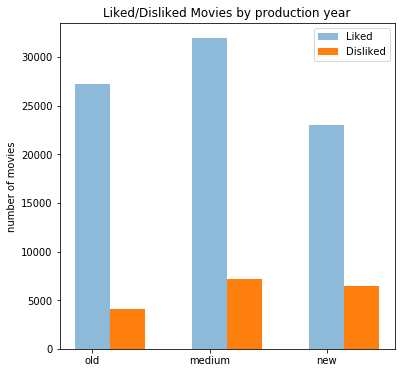

In [443]:
# plotting the distribution of likes and dislikes of movies based on the production year of the movie
movietype=('old','medium','new')
mlike=[]
mdislike=[]
for i in range(1,4):
    mlike.append((liked['scaledyear']==i).sum())
    mdislike.append((disliked['scaledyear']==i).sum())

    
mlikes = np.array(mlike)
mdislikes = np.array(mdislike)
x=list(range(0,3))
x=[i*2 for i in x]
ind = np.array(x)
width=.60       
plt.bar(ind, mlikes, width, label='Liked',alpha=0.5)
plt.bar(ind + width, mdislikes, width,label='Disliked')

plt.ylabel('number of movies')
plt.title('Liked/Disliked Movies by production year')

plt.xticks(ind , movietype)
plt.legend(loc='best')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size 
print "Current figure size:", fig_size
plt.savefig('class by year')
plt.show()



In [452]:
def fit_model(X_train, y_train,X_test, y_test,av):
    """ Performs grid search over the 'max_depth' parameter for a
        decision tree classifier trained on the input data [X, y]. """

    # Create cross-validation sets from the training data

    cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.10, random_state = 0)

    # Creating a decision tree classifier object
    model = DecisionTreeClassifier(random_state=0)

    # Creating a dictionary for the parameter 'max_depth' with a range from 1 to 22
    dt_range = range(1, 22)
    params = dict(max_depth=dt_range)


    # Creating the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(model, params,scoring=None, cv=cv_sets)
    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    
    return (round(recall_score(y_test, y_pred, average=av),2)), (round(precision_score(y_test, y_pred, average=av),2)),(round(f1_score(y_test, y_pred, average=av),2)),grid.best_estimator_




def DT(av):
    ###
    #training a DT Classifier
    
    #Shuffle and split the data into training and testing subsets

    #fitting a model (DT Classifier)

    ###
    print("Preparing the data for the DT classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns")
    #DTdata=pd.DataFrame(ratingdata.set_index('movieId').join(moviedata.set_index('movieId')))
    DTdata=pd.DataFrame(ratingdata[['userId', 'rating','movieId']].merge(moviedata[['scaledyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner'))
    #DTdata.drop('movieId', axis=1)
    ratings=DTdata['rating']
    del DTdata['movieId']
    del DTdata['rating']
    # print(DTdata)
    # print(DTdata.shape)


    ###
    X_train, X_test, y_train, y_test = train_test_split(DTdata, ratings, test_size=0.2, random_state=0)

    # if splitting successful, print Success
    # print "Training and testing split was successful."

    DTrecall,DTprecision,DTf1score,estim=fit_model(X_train, y_train,X_test,y_test,av)
    
    ###

    return DTrecall,DTprecision,DTf1score,estim


In [453]:
f1scores=[] #this will contain the maximum f1 score for each of the models
listofDTf1scores=[] #will contain 2 f1 scores for the DT model
#Decision Tree Classiifer
DTrecall,DTprecision,DTf1score,reg=DT('micro')
#printing the max_depth value that produces the highest F1 score
#printing the max_depth value that produces the highest F1 scores using type of averaging performed on the data ='weighted'
# Calculate metrics globally by counting the total true positives, false negatives and false positives. 
print ("Calculating the metrics using average='micro'")
print ("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))
#storing the f1 score:

listofDTf1scores.append(DTf1score)
print("Using the Decission Tree Classifier, the Recall Score= %.2f " %DTrecall)
print("Using the Decission Tree Classifier, the Precision Score= %.2f " %DTprecision)
print("Using the Decission Tree Classifier, the F1 Score= %.2f " %DTf1score)
print('')

DTrecall,DTprecision,DTf1score,reg=DT('weighted')
#printing the max_depth value that produces the highest F1 scores using type of averaging performed on the data ='weighted'
# which Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). 
print ("Calculating the metrics using average='weighted'")
print ("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))
#storing the f1 score:
listofDTf1scores.append(DTf1score)
f1scores.append(max(listofDTf1scores))
print("Using the Decission Tree Classifier, the Recall Score= %.2f " %DTrecall)
print("Using the Decission Tree Classifier, the Precision Score= %.2f " %DTprecision)
print("Using the Decission Tree Classifier, the F1 Score= %.2f " %DTf1score)


Preparing the data for the DT classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns
Calculating the metrics using average='micro'
Parameter 'max_depth' is 9 for the optimal model.
Using the Decission Tree Classifier, the Recall Score= 0.83 
Using the Decission Tree Classifier, the Precision Score= 0.83 
Using the Decission Tree Classifier, the F1 Score= 0.83 

Preparing the data for the DT classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns
Calculating the metrics using average='weighted'
Parameter 'max_depth' is 9 for the optimal model.
Using the Decission Tree Classifier, the Recall Score= 0.83 
Using the Decission Tree Classifier, the Precision Score= 0.78 
Using the Decission Tree Classifier, the F1 Score= 0.77 


In [188]:
def KNN(userNNdata, ratings,av):

    # classifier = DecisionTreeClassifier()
    # classifier.fit(X_train, y_train)

    #fitting a KNN classifier
    neigh = KNeighborsClassifier(n_neighbors=5,weights='uniform')
    X_train, X_test, y_train, y_test = train_test_split(userNNdata, ratings, test_size=0.2, random_state=0)
    # print "Training and testing split was successful."
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)

    return f1_score(y_test, y_pred, average=av), recall_score(y_test, y_pred, average=av),precision_score(y_test, y_pred, average=av)


def KNNclassifier(users,av):
    print("Preparing the data for the KNN classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns")
    NNdata=ratingdata[['userId', 'rating','movieId']].merge(moviedata[['minmaxyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner')

    del NNdata['movieId']


    #calling the function KNN
    f1score=0
    recal=0
    precisio=0
    for u in users:
        userId=u
        userNNdata=NNdata.loc[NNdata['userId'] == userId]
        ratings=userNNdata['rating']
        del userNNdata['rating']
        del userNNdata['userId']

        # print (userNNdata)
        score,recall,precision=KNN(userNNdata, ratings,av)
        f1score+=score
        recal+=recall
        precisio+=precision
    return  (round((float(recal)/len(users)),2)),(round((float(precisio)/len(users)),2)),(round((float(f1score)/len(users)),2))   
    


In [454]:
listofKNNf1scores=[] #will contain 2 f1 scores for the KNN model
#K Nearest Nieghour Classifier
KNNrecall,KNNprecision,KNNf1score=KNNclassifier(users, av='micro')
#storing the f1 score
listofKNNf1scores.append(KNNf1score)

print(" ")
print ("Calculating the metrics using average='micro'")
print ("Using The K Nearest Neighbour Classifier, the  Recall Score = %.2f" %(KNNrecall))
print ("Using The K Nearest Neighbour Classifier, the  Precision Score = %.2f" %(KNNprecision))
print ("Using The K Nearest Neighbour Classifier, the  F1 Score = %.2f" %(KNNf1score))
print ("")

KNNrecall,KNNprecision,KNNf1score=KNNclassifier(users, av='weighted')
#storing the f1 score
listofKNNf1scores.append(KNNf1score)
f1scores.append(max(listofKNNf1scores))
print(" ")
print ("Calculating the metrics using average='weighted'")
print ("Using The K Nearest Neighbour Classifier, the  Recall Score = %.2f" %(KNNrecall))
print ("Using The K Nearest Neighbour Classifier, the  Precision Score = %.2f" %(KNNprecision))
print ("Using The K Nearest Neighbour Classifier, the  F1 Score = %.2f" %(KNNf1score))



Preparing the data for the KNN classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns
 
Calculating the metrics using average='micro'
Using The K Nearest Neighbour Classifier, the  Recall Score = 0.85
Using The K Nearest Neighbour Classifier, the  Precision Score = 0.85
Using The K Nearest Neighbour Classifier, the  F1 Score = 0.85

Preparing the data for the KNN classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns
 
Calculating the metrics using average='weighted'
Using The K Nearest Neighbour Classifier, the  Recall Score = 0.85
Using The K Nearest Neighbour Classifier, the  Precision Score = 0.80
Using The K Nearest Neighbour Classifier, the  F1 Score = 0.82


In [191]:
def Rforest(av):
    print("preparing the data for the Random Forest Classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns")
    #DTdata=pd.DataFrame(ratingdata.set_index('movieId').join(moviedata.set_index('movieId')))
    RFdata=pd.DataFrame(ratingdata[['userId', 'rating','movieId']].merge(moviedata[['scaledyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner'))
    #DTdata.drop('movieId', axis=1)
    ratings=RFdata['rating']
    del RFdata['movieId']
    del RFdata['rating']
    # print(DTdata)
    # print(DTdata.shape)


    ###
    X_train, X_test, y_train, y_test = train_test_split(RFdata, ratings, test_size=0.2)

    # if splitting successful, print Success
    # print "Training and testing split was successful."
    # for increasing the F1-score, I tuned the parameters by adding max_features=None the default is 'auto', so the score increased from 
    #79% to 80%
    # and increasing the number of jobs from 2 to 10 increased the score to 81%
    clf = RandomForestClassifier(n_jobs=10,max_features=None)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    return (round(recall_score(y_test, y_pred, average=av),2)),(round(precision_score(y_test, y_pred, average=av),2)),(round(f1_score(y_test, y_pred, average=av),2))
    

    ###



In [455]:
listofRFf1scores=[] #will contain 2 f1 scores for the Random Froest model
#Random Forest Classifier
RFrecall,RFprecision,RFf1score=Rforest(av='micro')
#storing the f1 score
listofRFf1scores.append(RFf1score)

print ("Calculating the metrics using average='micro'")
print("\nUsing the Random Forest Classifier, the Recall Score= %.2f " %(RFrecall))
print("Using the Random Forest Classifier, the Precision Score= %.2f " %(RFprecision))
print("Using the Random Forest Classifier, the F1 Score= %.2f " %(RFf1score))
print("")


RFrecall,RFprecision,RFf1score=Rforest(av='weighted')
#storing the f1 score
listofRFf1scores.append(RFf1score)
f1scores.append(max(listofRFf1scores))

print ("Calculating the metrics using average='weighted'")
print("\nUsing the Random Forest Classifier, the Recall Score= %.2f " %(RFrecall))
print("Using the Random Forest Classifier, the Precision Score= %.2f " %(RFprecision))
print("Using the Random Forest Classifier, the F1 Score= %.2f " %(RFf1score))



preparing the data for the Random Forest Classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns
Calculating the metrics using average='micro'

Using the Random Forest Classifier, the Recall Score= 0.81 
Using the Random Forest Classifier, the Precision Score= 0.81 
Using the Random Forest Classifier, the F1 Score= 0.81 

preparing the data for the Random Forest Classifier by joining the two data frames 'ratingdata' and 'moviedata' and displaying only relevant columns
Calculating the metrics using average='weighted'

Using the Random Forest Classifier, the Recall Score= 0.80 
Using the Random Forest Classifier, the Precision Score= 0.78 
Using the Random Forest Classifier, the F1 Score= 0.79 


In [461]:

def lightGBM(ratingdata,users,av):
    #### LightGBM
    lgbmdata=ratingdata[['userId', 'rating','movieId']].merge(moviedata[['minmaxyear', 'Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','Documentary','IMAX','War','Musical','Western','Film-Noir','movieId']], on='movieId', how='inner')
    totalrecall=0
    totalprecision=0
    totalfscore=0
    for u in tqdm(users):
        userId=u

        Tlgbmdata=lgbmdata.loc[lgbmdata['userId'] == userId]
        ratings=Tlgbmdata['rating']
        del Tlgbmdata['movieId']
        del Tlgbmdata['rating']
        del Tlgbmdata['userId']
  
        userf1=0
        userprecision=0
        userrecall=0
        for i in range(0,10):
            X_train, X_test, y_train, y_test = train_test_split(Tlgbmdata, ratings, test_size=0.2)
            # print "Training and testing split was successful."
            #converting the training data into LightGBM dataset format
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)
            d_train = lgb.Dataset(X_train, label=y_train)
            params = {}
            params['learning_rate'] = 0.003
            params['boosting_type'] = 'gbdt'
            params['objective'] = 'binary'
            params['metric'] = 'binary_logloss'
            params['sub_feature'] = 0.8
            params['num_leaves'] = 20
            params['max_depth'] = -1
            params['min_data_in_leaf']=5
            

            clf = lgb.train(params, d_train, 100)


            #Prediction
            y_pred=clf.predict(X_test)
            #since the output of the LightGBM is a probability list each number specifiing the probability of belonging
            #to a class or not.
            #I will traverse each output and transform the probability to belong to one of the classes [0 or 1]
            #I set the threshold to 0.5, if the output is higher or equal to 0.5 I will assume the user liked the movie,
            #otherwise i will assume he didnt like it.
            y_predList=[]
            for y in y_pred:
                if y<0.5:       # setting threshold to 0.5
                    y_predList.append(0)
                else:
                    y_predList.append(1)
                

            #Confusion matrix

            cm = confusion_matrix(y_test, y_predList)
            # print (cm)
            #Accuracy

            accuracy=f1_score(y_predList,y_test, average=av)
            #print (accuracy)
            userf1+=accuracy
            userrecall+=recall_score(y_predList,y_test, average=av)
            userprecision+=precision_score(y_predList,y_test, average=av)

        userf1/=10
        userrecall/=10
        userprecision/=10
        totalfscore+=userf1
        totalrecall+=userrecall
        totalprecision+=userprecision
    return (round(totalrecall/len(users),2)),(round(totalprecision/len(users),2)),(round(totalfscore/len(users),2))


In [464]:
listofLightGBMf1scores=[] #will contain 2 f1 scores for the LightGBM model


#LightGBM Classifier
Lrecall,Lprecision,Lf1score=lightGBM(ratingdata,users,av='micro')

#storing the f1 score
listofLightGBMf1scores.append(Lf1score)

print(" ")
print ("Calculating the metrics using average='micro'")
print ("Using the LightGBM, the Recall Score =%.2f" %Lrecall)
print ("Using the LightGBM, the F1 Precision =%.2f" %Lprecision)
print ("Using the LightGBM, the F1 Score =%.2f" %Lf1score)

#
Lrecall,Lprecision,Lf1score=lightGBM(ratingdata,users,av='weighted')

#storing the f1 score
listofLightGBMf1scores.append(Lf1score)
f1scores.append(max(listofLightGBMf1scores))


print(" ")
print ("Calculating the metrics using average='weighted'")
print ("Using the LightGBM, the Recall Score =%.2f" %Lrecall)
print ("Using the LightGBM, the F1 Precision =%.2f" %Lprecision)
print ("Using the LightGBM, the F1 Score =%.2f" %Lf1score)









  0%|          | 0/671 [00:00<?, ?it/s]




  0%|          | 1/671 [00:00<04:49,  2.32it/s]








  0%|          | 2/671 [00:01<05:53,  1.89it/s]




  0%|          | 3/671 [00:02<08:10,  1.36it/s]




  1%|          | 4/671 [00:03<07:55,  1.40it/s]




  1%|          | 5/671 [00:04<08:41,  1.28it/s]




  1%|          | 6/671 [00:04<07:52,  1.41it/s]




  1%|          | 7/671 [00:05<08:18,  1.33it/s]




  1%|          | 8/671 [00:06<08:35,  1.29it/s]




  1%|▏         | 9/671 [00:06<07:50,  1.41it/s]




  1%|▏         | 10/671 [00:07<07:09,  1.54it/s]




  2%|▏         | 11/671 [00:07<06:19,  1.74it/s]




  2%|▏         | 12/671 [00:08<06:15,  1.76it/s]




  2%|▏         | 13/671 [00:09<07:45,  1.41it/s]




  2%|▏         | 14/671 [00:09<07:39,  1.43it/s]




  2%|▏         | 15/671 [00:10<07:40,  1.42it/s]




  2%|▏         | 16/671 [00:11<06:53,  1.58it/s]




  3%|▎         | 17/671 [00:11<06:12,  1.76it/s]




  3%|▎         | 18/671 [00:12<07:22,  1.48it/s]




  

 18%|█▊        | 120/671 [01:47<08:04,  1.14it/s]




 18%|█▊        | 121/671 [01:48<06:57,  1.32it/s]




 18%|█▊        | 122/671 [01:48<06:49,  1.34it/s]




 18%|█▊        | 123/671 [01:49<06:41,  1.37it/s]




 18%|█▊        | 124/671 [01:50<07:32,  1.21it/s]




 19%|█▊        | 125/671 [01:51<06:39,  1.37it/s]




 19%|█▉        | 126/671 [01:52<07:20,  1.24it/s]




 19%|█▉        | 127/671 [01:52<06:19,  1.43it/s]




 19%|█▉        | 128/671 [01:52<05:26,  1.66it/s]




 19%|█▉        | 129/671 [01:53<05:23,  1.67it/s]




 19%|█▉        | 130/671 [01:53<04:44,  1.90it/s]




 20%|█▉        | 131/671 [01:54<05:32,  1.62it/s]




 20%|█▉        | 132/671 [01:55<07:02,  1.28it/s]




 20%|█▉        | 133/671 [01:56<07:01,  1.28it/s]




 20%|█▉        | 134/671 [01:56<05:49,  1.54it/s]




 20%|██        | 135/671 [01:57<05:43,  1.56it/s]




 20%|██        | 136/671 [01:58<06:30,  1.37it/s]




 20%|██        | 137/671 [01:59<07:21,  1.21it/s]




 21%|██        | 138/671 [02

 35%|███▌      | 238/671 [03:19<06:17,  1.15it/s]




 36%|███▌      | 239/671 [03:19<05:34,  1.29it/s]




 36%|███▌      | 240/671 [03:20<05:06,  1.41it/s]




 36%|███▌      | 241/671 [03:21<05:46,  1.24it/s]




 36%|███▌      | 242/671 [03:21<04:51,  1.47it/s]




 36%|███▌      | 243/671 [03:21<04:14,  1.68it/s]




 36%|███▋      | 244/671 [03:22<05:09,  1.38it/s]




 37%|███▋      | 245/671 [03:24<06:22,  1.11it/s]




 37%|███▋      | 246/671 [03:24<05:49,  1.22it/s]




 37%|███▋      | 247/671 [03:25<04:52,  1.45it/s]




 37%|███▋      | 248/671 [03:26<06:04,  1.16it/s]




 37%|███▋      | 249/671 [03:27<05:32,  1.27it/s]




 37%|███▋      | 250/671 [03:27<04:47,  1.46it/s]




 37%|███▋      | 251/671 [03:28<06:12,  1.13it/s]




 38%|███▊      | 252/671 [03:29<05:46,  1.21it/s]




 38%|███▊      | 253/671 [03:30<05:15,  1.33it/s]




 38%|███▊      | 254/671 [03:31<06:25,  1.08it/s]




 38%|███▊      | 255/671 [03:32<07:06,  1.03s/it]




 38%|███▊      | 256/671 [03

 53%|█████▎    | 356/671 [04:51<03:34,  1.47it/s]




 53%|█████▎    | 357/671 [04:51<03:10,  1.64it/s]




 53%|█████▎    | 358/671 [04:52<02:52,  1.81it/s]




 54%|█████▎    | 359/671 [04:52<03:18,  1.57it/s]




 54%|█████▎    | 360/671 [04:53<03:42,  1.40it/s]




 54%|█████▍    | 361/671 [04:54<04:13,  1.22it/s]




 54%|█████▍    | 362/671 [04:56<05:07,  1.00it/s]




 54%|█████▍    | 363/671 [04:56<04:21,  1.18it/s]




 54%|█████▍    | 364/671 [04:57<04:06,  1.25it/s]




 54%|█████▍    | 365/671 [04:58<04:27,  1.14it/s]




 55%|█████▍    | 366/671 [04:59<04:14,  1.20it/s]




 55%|█████▍    | 367/671 [04:59<03:33,  1.42it/s]




 55%|█████▍    | 368/671 [05:00<03:20,  1.51it/s]




 55%|█████▍    | 369/671 [05:01<03:36,  1.40it/s]




 55%|█████▌    | 370/671 [05:02<04:11,  1.20it/s]




 55%|█████▌    | 371/671 [05:03<04:24,  1.13it/s]




 55%|█████▌    | 372/671 [05:03<04:08,  1.21it/s]




 56%|█████▌    | 373/671 [05:04<03:41,  1.34it/s]




 56%|█████▌    | 374/671 [05

 71%|███████   | 474/671 [06:21<02:26,  1.34it/s]




 71%|███████   | 475/671 [06:21<02:06,  1.55it/s]




 71%|███████   | 476/671 [06:22<02:22,  1.37it/s]




 71%|███████   | 477/671 [06:23<02:17,  1.41it/s]




 71%|███████   | 478/671 [06:24<02:39,  1.21it/s]




 71%|███████▏  | 479/671 [06:25<02:55,  1.10it/s]




 72%|███████▏  | 480/671 [06:26<02:27,  1.30it/s]




 72%|███████▏  | 481/671 [06:26<02:06,  1.51it/s]




 72%|███████▏  | 482/671 [06:27<02:21,  1.34it/s]




 72%|███████▏  | 483/671 [06:28<02:48,  1.12it/s]




 72%|███████▏  | 484/671 [06:29<02:31,  1.24it/s]




 72%|███████▏  | 485/671 [06:29<02:13,  1.39it/s]




 72%|███████▏  | 486/671 [06:31<02:48,  1.10it/s]




 73%|███████▎  | 487/671 [06:32<03:03,  1.01it/s]




 73%|███████▎  | 488/671 [06:33<03:04,  1.01s/it]




 73%|███████▎  | 489/671 [06:34<02:44,  1.11it/s]




 73%|███████▎  | 490/671 [06:35<02:47,  1.08it/s]




 73%|███████▎  | 491/671 [06:36<02:51,  1.05it/s]




 73%|███████▎  | 492/671 [06

 88%|████████▊ | 592/671 [07:57<01:07,  1.17it/s]




 88%|████████▊ | 593/671 [07:58<01:11,  1.10it/s]




 89%|████████▊ | 594/671 [07:59<01:13,  1.05it/s]




 89%|████████▊ | 595/671 [08:00<01:11,  1.07it/s]




 89%|████████▉ | 596/671 [08:00<00:58,  1.29it/s]




 89%|████████▉ | 597/671 [08:01<00:52,  1.40it/s]




 89%|████████▉ | 598/671 [08:01<00:46,  1.59it/s]




 89%|████████▉ | 599/671 [08:02<00:46,  1.56it/s]




 89%|████████▉ | 600/671 [08:03<00:48,  1.46it/s]




 90%|████████▉ | 601/671 [08:04<00:51,  1.37it/s]




 90%|████████▉ | 602/671 [08:05<01:01,  1.13it/s]




 90%|████████▉ | 603/671 [08:06<01:04,  1.05it/s]




 90%|█████████ | 604/671 [08:07<00:54,  1.23it/s]




 90%|█████████ | 605/671 [08:07<00:45,  1.46it/s]




 90%|█████████ | 606/671 [08:08<00:50,  1.28it/s]




 90%|█████████ | 607/671 [08:08<00:42,  1.52it/s]




 91%|█████████ | 608/671 [08:09<00:36,  1.71it/s]




 91%|█████████ | 609/671 [08:10<00:49,  1.26it/s]




 91%|█████████ | 610/671 [08

 
Calculating the metrics using average='micro'
Using the LightGBM, the Recall Score =0.76
Using the LightGBM, the F1 Precision =0.76
Using the LightGBM, the F1 Score =0.76


100%|██████████| 671/671 [13:53<00:00,  1.17it/s]    

 
Calculating the metrics using average='weighted'
Using the LightGBM, the Recall Score =0.76
Using the LightGBM, the F1 Precision =0.86
Using the LightGBM, the F1 Score =0.79


In [465]:
# comparing the F1-Score of the four models
classes=('Decision Tree','K Nearest Neighbour','Random Forest','LightGBM')
print("The model that scored the highest F1-Score is %s with a score of  = %.0f%%"
      %(classes[f1scores.index(max(f1scores))], max(f1scores)*100))

The model that scored the highest F1-Score is K Nearest Neighbour with a score of  = 85%


Current figure size: [6, 4]


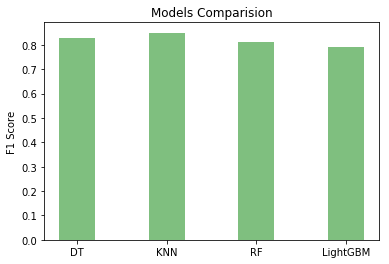

In [470]:
#plooting the distribution of the f1 score of the four models that I trained
classes=('DT','KNN','RF','LightGBM')
width = 0.40       # the width of the bars
y_pos = np.arange(len(classes))
plt.bar(y_pos, f1scores, width,align='center', color= 'green' ,alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('F1 Score')
plt.title('Models Comparision')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size 
print "Current figure size:", fig_size
plt.savefig('my model comparision')

plt.show()



In [471]:
def userCollaborativeFiltering():
# first I will create a dictionary with the preferences of each of the 700 users
#I am reading the ratings.csv file and I will leave the rating field as is with no discretization
    ratingdata=pd.read_csv('ratings.csv')
    preferences={}
    for index, record in ratingdata.iterrows():
        if int(record['userId']) in preferences.keys():
            preferences[int(record['userId'])][int(record['movieId'])]=int(record['rating'])
        else:
            preferences[int(record['userId'])] = {}
            preferences[int(record['userId'])][int(record['movieId'])]=int(record['rating'])
    return preferences

# second I will calculate the similarity score between each user to those who rated the same movies with the user using a Euclidean distance score
def sim_distance(preferences,user1,user2):
      # Get the list of shared_items
    si={}
    for item in preferences[user1]:
        if item in preferences[user2]:
            si[item]=1
  # if they have no ratings in common, return 0
    if len(si)==0:
        return 0
  # Add up the squares of all the differences
    
    sum_of_squares=sum([pow(preferences[user1][item]-preferences[user2][item],2)
                      for item in si.keys()])

    return 1.0/(1.0+sum_of_squares)




In [472]:
#the benchmark model "User-Based Collaborative Filtering"
# first I will create a dictionary with the preferences of each of the 700 users
preferences=userCollaborativeFiltering()
print (preferences)

{1: {1953: 4, 1339: 3, 1061: 3, 2150: 3, 1287: 2, 2193: 2, 1129: 2, 3671: 3, 1293: 2, 1263: 2, 1343: 2, 1172: 4, 2294: 2, 2455: 2, 2968: 1, 2105: 4, 1371: 2, 31: 2, 1405: 1, 1029: 3}, 2: {515: 4, 261: 4, 265: 5, 10: 4, 527: 4, 144: 3, 17: 5, 405: 2, 150: 5, 537: 4, 485: 3, 153: 4, 410: 3, 367: 3, 497: 3, 161: 3, 539: 3, 292: 3, 165: 3, 550: 3, 39: 5, 168: 3, 551: 5, 300: 3, 500: 4, 47: 4, 50: 4, 52: 3, 350: 4, 585: 5, 185: 3, 186: 3, 509: 4, 266: 5, 62: 3, 319: 1, 272: 3, 454: 4, 552: 3, 457: 3, 586: 3, 587: 3, 588: 3, 589: 5, 590: 5, 208: 3, 593: 3, 339: 3, 468: 4, 592: 5, 474: 2, 314: 4, 222: 5, 223: 1, 480: 4, 225: 3, 356: 3, 357: 3, 273: 4, 616: 3, 235: 3, 364: 3, 720: 4, 110: 4, 317: 2, 296: 4, 370: 2, 371: 3, 372: 3, 349: 4, 248: 3, 377: 3, 508: 4, 253: 4, 382: 3, 661: 4}, 3: {2694: 3, 778: 4, 267: 3, 84236: 4, 2318: 4, 527: 3, 50068: 4, 2841: 4, 8636: 3, 2716: 3, 44191: 3, 5669: 3, 296: 4, 2858: 4, 3243: 3, 1580: 3, 1197: 5, 8622: 3, 3510: 4, 1721: 4, 1210: 3, 60: 3, 318: 5, 585

In [473]:
# second I will calculate the similarity score between each user to those who rated the same movies with the user using a Euclidean distance score
similarity={}
for i in tqdm(range(0,len(users))):
    for user2 in users[i+1:]:
        score=sim_distance(preferences,users[i],user2)
        if int(users[i]) in similarity.keys():
            similarity[int(users[i])][int(user2)]=score 
        else:
            similarity[int(users[i])]={}
            similarity[int(users[i])][int(user2)]=score             


100%|██████████| 671/671 [00:14<00:00, 45.35it/s] 


In [474]:
print (similarity[660])

{661: 0.3333333333333333, 662: 0.2, 663: 0.038461538461538464, 664: 0.023255813953488372, 665: 0.03225806451612903, 666: 0.045454545454545456, 667: 0.25, 668: 0.038461538461538464, 669: 0.3333333333333333, 670: 0.03225806451612903, 671: 0.043478260869565216}


In [475]:
# Gets recommendations for a person by using a weighted average
# of every other user's rankings
def getRecommendations(prefs,person,x,similarity=sim_distance):
    scores = []
    ratings = []
    percision=0
    recall=0
    fscore=0
    for item in prefs[person]:
#         if prefs[person][item]>= 3.0:
#             continue
        totals={}
        simSums={}
        for other in prefs:
            # don't compare the user to himself
            if other==person:
                continue
            sim=similarity(prefs,person,other)
            # ignore scores of zero or lower
            if sim<=0:
                continue
            if item in prefs[other]:
                # Similarity * Score
                totals.setdefault(item,0)
                totals[item]+=prefs[other][item]*sim
                # Sum of similarities
                simSums.setdefault(item,0)
                simSums[item]+=sim
        if item in totals:
            scores.append(0 if totals[item]/simSums[item]>=3.0 else 1)
            ratings.append(0 if prefs[person][item]>=3.0 else 1)

    dfscore=f1_score(scores,ratings, average=x)           
    recall=recall_score(scores,ratings, average=x)
    percision=precision_score(scores,ratings,  average=x)
    return percision, recall, dfscore



In [477]:
#Calculating the metrics using average='micro' then using the average='weighted in the next cell
benchmarkf1score=[] #to store the two f1 scores obtained by the different types of averaging 'micro' and 'weighted'
totalprecision=0
totalrecal=0
totalf1score=0
nonparticipants=0
for user in tqdm(users):
    p,r,f=getRecommendations(preferences,user,x='micro',similarity=sim_distance)
    totalprecision+=p
    totalrecal+=r
    totalf1score+=f
    
print("Calculating the metrics using average='micro'")    
print("Using the User_based CF, The Recall = %.2f" %(1.0*(totalrecal/len(users))))
print("Using the User_based CF, The Precision = %.2f" %(1.0*(totalprecision/len(users))))
print("Using the User_based CF, The F1 Score =   %.2f" %(1.0*(totalf1score/len(users))))
benchmarkf1score.append(round(1.0*(totalf1score/len(users))))


  0%|          | 3/671 [00:01<05:12,  2.14it/s]

 24%|██▎       | 159/671 [19:21<29:31,  3.46s/it]


 48%|████▊     | 324/671 [37:12<07:51,  1.36s/it]


 73%|███████▎  | 487/671 [1:08:33<11:02,  3.60s/it]


 96%|█████████▌| 642/671 [1:46:06<00:25,  1.15it/s]


100%|██████████| 671/671 [2:12:31<00:00, 54.56s/it]

Calculating the metrics using average='micro'
Using the User_based CF, The Recall = 0.84
Using the User_based CF, The Precision = 0.84
Using the User_based CF, The F1 Score =   0.84


In [479]:
totalprecision=0
totalrecal=0
totalf1score=0
nonparticipants=0
for user in tqdm(users):
    p,r,f=getRecommendations(preferences,user,x='weighted', similarity=sim_distance)
    totalprecision+=p
    totalrecal+=r
    totalf1score+=f
    

print("Calculating the metrics using average='weighted'")
print("Using the User_based CF, The Recall = %.2f" %(1.0*(totalrecal/len(users))))
print("Using the User_based CF, The Precision = %.2f" %(1.0*(totalprecision/len(users))))
print("Using the User_based CF, The F1 Score =   %.2f" %(1.0*(totalf1score/len(users))))
benchmarkf1score.append(round(1.0*(totalf1score/len(users))))
f1scores.append(max(benchmarkf1score))    



100%|██████████| 671/671 [13:01:24<00:00,  2.67s/it]     

Calculating the metrics using average='weighted'
Using the User_based CF, The Recall = 0.84
Using the User_based CF, The Precision = 0.86
Using the User_based CF, The F1 Score =   0.84


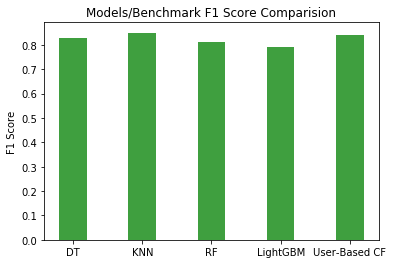

In [483]:
#plotting the highest F1 scores obtained by my four models against the F1 score obtained by the bench mark model "user based collaborative filtering

models=('DT','KNN','RF','LightGBM','User-Based CF')
width = 0.40       # the width of the bars
y_pos = np.arange(len(models))
plt.bar(y_pos, f1scores, width,align='center', color= 'green' ,alpha=0.5)
plt.xticks(y_pos, models)
plt.ylabel('F1 Score')
plt.title('Models/Benchmark F1 Score Comparision')
plt.savefig('model_benchmark_f1score') 
plt.show()





In [490]:
#Printing the models sorted in descending order based on the achieved F1 Score
models=list(models)
sorted_f1scores,sorted_models=[list(x) for x in zip(*sorted(zip(f1scores, models), key=lambda pair: pair[0]))]
print("Printing the models starting with the model that has the highest F1 Score and ending with the one that has the least")
for x,y in zip(reversed(sorted_models),reversed(sorted_f1scores)):
    print(x, y) 
    
    

Printing the models starting with the model that has the highest F1 Score and ending with the one that has the least
('KNN', 0.85)
('User-Based CF', 0.84)
('DT', 0.83)
('RF', 0.81)
('LightGBM', 0.79)


In [ ]:
#the end